# Run Inference

Galen's recommended model with no context features `20e_slid_win_no_feats_r18.pt`

From Galen - *Here's the model I would use for transfer learning. It's trained for 20 epochs on the entire sliding window training set.* 

In [1]:
import fastai
import pandas as pd
import os
import s3fs # for reading from S3FileSystem
import json


import torch.nn as nn
import torch
import torch.utils.model_zoo as model_zoo
import numpy as np

fastai.version

<module 'fastai.version' from '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/version.py'>

In [ ]:
# Transfer Learning with PyTorch.Vision Tutorial
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

## Load the Model

In [3]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'

MODEL_PATH = os.path.join(SAGEMAKER_PATH, r'sidewalk-cv-assets19/pytorch_pretrained/models/20e_slid_win_no_feats_r18.pt')

In [4]:
os.path.exists(MODEL_PATH)

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
help(models.resnet18())

Help on ResNet in module torchvision.models.resnet object:

class ResNet(torch.nn.modules.module.Module)
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super(Model, self).__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call :meth:`to`, etc.
 |  
 |  Method resolution order:
 |      ResNet
 |      torch.nn.modules.module.Module


In [18]:
import torchvision.models as models
model = models.resnet18()
#model = model.to(device)
model.to(device)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Running into some errors with the machine - need some sort of GPU to try to load (since that's what we'll actually use!)
model.load_state_dict(torch.load(MODEL_PATH))
#model.load_state_dict(torch.load(MODEL_PATH),map_location=torch.device('cpu'))
#model = torch.load(MODEL_PATH, map_location=torch.device(device))
model.eval() # This line causes an error on Galen's model

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# Try to review contents of the Model
* What data structure / type - it's an OrderedDict
* Looking at keys 
* Trying to get a slide view

In [16]:
#from torchsummary import summary

#summary(model)

In [19]:
# https://stackoverflow.com/questions/42480111/model-summary-in-pytorch


from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

# Test
import torchvision.models as models

#print(torch_summarize(model))

AttributeError: 'collections.OrderedDict' object has no attribute '_modules'

In [21]:
type(model)

collections.OrderedDict

In [ ]:
# Docs on OrderedDict datatype - https://docs.python.org/3/library/collections.html#collections.OrderedDict

# Examples and comments on OrderedDict https://www.geeksforgeeks.org/ordereddict-in-python/

In [24]:
# General Dictionary Functionality - https://www.tutorialspoint.com/python3/python_dictionary.htm

# Try to get the keys
model.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [31]:
# Try to get the shape of each item
fc_weight = model['fc.weight']
print(type(fc_weight))
print(list(fc_weight.shape))

<class 'torch.Tensor'>
[5, 512]


In [43]:
list_model_keys = list(model.keys())
print(len(list_model_keys))
df_model = pd.Series( (v for v in list_model_keys))
df_model.head()

122


0        conv1.weight
1          bn1.weight
2            bn1.bias
3    bn1.running_mean
4     bn1.running_var
dtype: object

In [47]:
list_shapes = [list(model[key_name].shape)  for key_name in list_model_keys]
df_model['shape'] = list_shapes
print(len(list_shapes))
df_model.head()

122


0        conv1.weight
1          bn1.weight
2            bn1.bias
3    bn1.running_mean
4     bn1.running_var
dtype: object

In [46]:
df_model_shape = pd.DataFrame({'layer_name' : list_model_keys, 'layer_shape' : list_shapes})

# Could consider multiplying the layer_shape information  

df_model_shape.head()

,layer_name,layer_shape
0,conv1.weight,"[64, 3, 7, 7]"
1,bn1.weight,[64]
2,bn1.bias,[64]
3,bn1.running_mean,[64]
4,bn1.running_var,[64]


In [52]:
list_shapes[0:10]

[[64, 3, 7, 7], [64], [64], [64], [64], [], [64, 64, 3, 3], [64], [64], [64]]

In [50]:
# Prints out the whole OrderedDict
#print(model)

In [53]:
# Print out a layer that's a good shape
print(model['bn1.weight'])

tensor([ 3.5964e-01,  4.2401e-01, -5.1096e-08,  6.1991e-01,  3.4404e-09,
         2.8786e-01,  5.3447e-01,  1.3153e-07,  3.4758e-01,  1.5152e-06,
         4.9390e-01,  3.2763e-01,  4.7919e-01,  1.0862e-05,  4.6069e-01,
         3.5157e-01,  3.8702e-01,  5.8939e-01,  5.1658e-01,  4.5447e-01,
         4.3300e-01,  3.7604e-01,  4.5489e-01,  3.1296e-01,  4.2755e-01,
         4.1018e-01,  4.5296e-01,  3.4541e-01,  3.8600e-01,  1.8146e-01,
         3.4643e-01,  2.9938e-01,  3.7171e-01,  4.3821e-01,  2.6094e-01,
         3.7318e-01,  7.4804e-08,  3.3223e-01,  1.4740e-08,  3.7321e-01,
         3.0091e-01,  3.2717e-01,  3.9960e-01,  3.6592e-01,  3.3923e-01,
         4.6867e-01,  2.9470e-01,  2.7326e-01,  2.2001e-08,  3.1250e-01,
         2.3703e-01,  4.1766e-01,  5.1300e-01,  2.4974e-01,  4.4040e-01,
         2.3683e-01,  3.2388e-01,  3.5957e-01,  6.6766e-01,  2.5994e-01,
         4.2522e-01,  3.5452e-01,  5.5115e-01,  3.6736e-01])


# Loading Images

* Cropped a couple of images from my A dataset and uploaded to S3 bucket in folder called `SampleTestImages`
* Want to see those images

Docs on s3fs -https://s3fs.readthedocs.io/en/latest/

In [54]:
#data_dir = '/data/train'

fs = s3fs.S3FileSystem()

# Docs on s3fs -https://s3fs.readthedocs.io/en/latest/

s3_image_bucket = 's3://streetview-w210'
sample_images_dir = os.path.join(s3_image_bucket, 'SampleTestImages')

# See what is in the folder
fs.ls(sample_images_dir)



['streetview-w210/SampleTestImages/12578_135_crop_missing.jpg',
 'streetview-w210/SampleTestImages/1908_135_crop_present.jpg']

In [55]:
# Grab first image
missing_path = os.path.join(sample_images_dir, os.path.basename(fs.ls(sample_images_dir)[0]))
missing_path

's3://streetview-w210/SampleTestImages/12578_135_crop_missing.jpg'

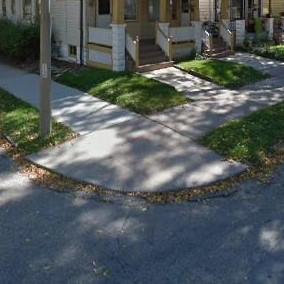

In [56]:
# Now let's try to read in the images

with fs.open(missing_path) as f:
    display(Image.open(f))

In [64]:
# Grab first image
curb_path = os.path.join(sample_images_dir, os.path.basename(fs.ls(sample_images_dir)[1]))
print(curb_path)

# Now let's try to read in the images

with fs.open(curb_path) as f:
    display(Image.open(f))

s3://streetview-w210/SampleTestImages/1908_135_crop_present.jpg


AttributeError: type object 'Image' has no attribute 'open'

In [ ]:
! mkdir images


In [66]:
! aws s3 cp s3://streetview-w210/SampleTestImages/1908_135_crop_present.jpg ./images/present.jpg

download: s3://streetview-w210/SampleTestImages/1908_135_crop_present.jpg to images/present.jpg


In [67]:
! aws s3 cp s3://streetview-w210/SampleTestImages/12578_135_crop_missing.jpg ./images/missing.jpg

download: s3://streetview-w210/SampleTestImages/12578_135_crop_missing.jpg to images/missing.jpg


## Code example from Internet for Inference

Blog Post: https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

Jupyter Notebook: https://github.com/cfotache/pytorch_imageclassifier/blob/master/PyTorch_Image_Inference.ipynb

In [16]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [26]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [71]:
def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [69]:
# THIS WORKS TO GET IMAGES

from fastai.vision import *
sagemaker_image_dir = './images'


fnames = get_image_files(sagemaker_image_dir)
fnames

[PosixPath('images/present.jpg'), PosixPath('images/missing.jpg')]

In [61]:
doc(get_image_files)

get_image_files [source] [test] get_image_files ( c : PathOrStr , check_ext : bool = True , recurse = False ) → FilePathList 
 
 × No tests found for get_image_files . To contribute a test please refer to this guide and this discussion . Return list of files in c that are images. check_ext will filter to image_extensions . 
 Show in docs

In [92]:
sagemaker_image_dir = './images'
print(os.listdir(sagemaker_image_dir))

data = datasets.ImageFolder(sagemaker_image_dir, transform=test_transforms)
data

num = 2

# classes = data.classes
indices = list(range(len(data)))
print(indices)
# np.random.shuffle(indices)
idx = indices[:num]
from torch.utils.data.sampler import SubsetRandomSampler

# We are using the sampling but we're taking 2 out of 2 
sampler = SubsetRandomSampler(idx)




loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
dataiter = iter(loader)
images = dataiter.next()
len(images)

['present.jpg', '.ipynb_checkpoints', 'missing.jpg']
[0]


2

In [95]:
type(images[0])

torch.Tensor

In [105]:
image_from_images = images[0]
image_from_images.shape

torch.Size([1, 3, 224, 224])

In [125]:
# Torch for squeeze to remove 4th dimension - https://pytorch.org/docs/stable/torch.html


image_squeezed = torch.squeeze(image_from_images)
image_squeezed.shape

torch.Size([3, 224, 224])

torch.Size([224, 224, 3])


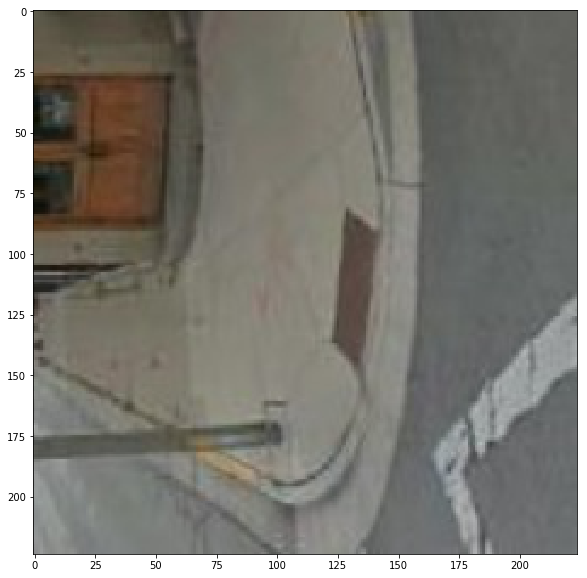

In [129]:
# Transpose - https://pytorch.org/docs/stable/torch.html#torch.transpose

transpose_image = torch.transpose(image_squeezed, 0, 2)
print(transpose_image.shape)

# Showing the image

fig=plt.figure(figsize=(10,10))
plt.imshow(transpose_image)

torch.Size([224, 224, 3])


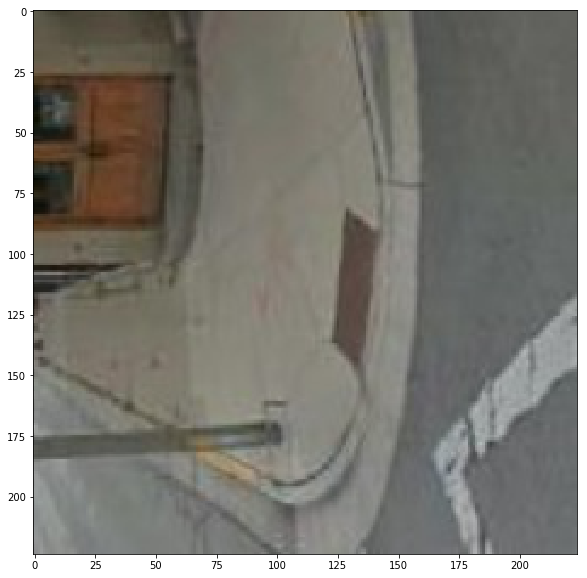

In [136]:
# Transpose - https://pytorch.org/docs/stable/torch.html#torch.transpose

transpose_image = torch.transpose(image_squeezed, 2, 0)
print(transpose_image.shape)

# Showing the image

fig=plt.figure(figsize=(10,10))
plt.imshow(transpose_image)

In [139]:
#index = predict_image(transpose_image, model)    
input = Variable(transpose_image)
input = input.to(device)
output = model(input)
output


# Need to update the loading - https://pytorch.org/tutorials/beginner/saving_loading_models.html

TypeError: 'collections.OrderedDict' object is not callable

In [72]:
doc(torch.utils.data.DataLoader)

class DataLoader [test] DataLoader ( dataset , batch_size = 1 , shuffle = False , sampler = None , batch_sampler = None , num_workers = 0 , collate_fn = 'default_collate' , pin_memory = True , drop_last = False , timeout = 0 , worker_init_fn = None ) 
 
 × No tests found for DataLoader . To contribute a test please refer to this guide and this discussion . Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset. 
 The :class: ~torch.utils.data.DataLoader supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning. 
 See :py:mod: torch.utils.data documentation page for more details. 
 Arguments:
 dataset (Dataset): dataset from which to load the data.
 batch_size (int, optional): how many samples per batch to load
 (default: 1 ).
 shuffle (bool, optional): set to True to have the data reshuffled
 at every epoch (default: False ).
 sampler (Sampler, optional): defines the strategy to draw samples from
 the dataset. If specified, :attr: shuffle must be False .
 batch_sampler (Sampler, optional): like :attr: sampler , but returns a batch of
 indices at a time. Mutually exclusive with :attr: batch_size ,
 :attr: shuffle , :attr: sampler , and :attr: drop_last .
 num_workers (int, optional): how many subprocesses to use for data
 loading. 0 means that the data will be loaded in the main process.
 (default: 0 )
 collate_fn (callable, optional): merges a list of samples to form a
 mini-batch of Tensor(s). Used when using batched loading from a
 map-style dataset.
 pin_memory (bool, optional): If True , the data loader will copy Tensors
 into CUDA pinned memory before returning them. If your data elements
 are a custom type, or your :attr: collate_fn returns a batch that is a custom type,
 see the example below.
 drop_last (bool, optional): set to True to drop the last incomplete batch,
 if the dataset size is not divisible by the batch size. If False and
 the size of dataset is not divisible by the batch size, then the last batch
 will be smaller. (default: False )
 timeout (numeric, optional): if positive, the timeout value for collecting a batch
 from workers. Should always be non-negative. (default: 0 )
 worker_init_fn (callable, optional): If not None , this will be called on each
 worker subprocess with the worker id (an int in [0, num_workers - 1] ) as
 input, after seeding and before data loading. (default: None ) 
 .. warning:: If the spawn start method is used, :attr: worker_init_fn 
 cannot be an unpicklable object, e.g., a lambda function. See
 :ref: multiprocessing-best-practices on more details related
 to multiprocessing in PyTorch. 
 .. note:: len(dataloader) heuristic is based on the length of the sampler used.
 When :attr: dataset is an :class: ~torch.utils.data.IterableDataset ,
 an infinite sampler is used, whose :meth: __len__ is not
 implemented, because the actual length depends on both the
 iterable as well as multi-process loading configurations. So one
 should not query this method unless they work with a map-style
 dataset. See Dataset Types _ for more details on these two types
 of datasets.

In [93]:
# Annie Customizing

to_pil = transforms.ToPILImage()
#images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

<Figure size 720x720 with 0 Axes>

# Try Accessing Images by copying over

In [74]:
fnames[0]

PosixPath('images/present.jpg')

In [82]:
img_pil = PIL.Image.open(data[0])
img_pil

AttributeError: 'tuple' object has no attribute 'read'

In [76]:
loader = torch.utils.data.DataLoader(fnames)
dataiter = iter(loader)
images, labels = dataiter.next()

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pathlib.PosixPath'>

In [75]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()
                                     ])


# data = datasets.ImageFolder(data_dir, transform=test_transforms)

to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(10,10))

# Need to convert image to tensor


my_image = to_pil(fnames[0])

TypeError: pic should be Tensor or ndarray. Got <class 'pathlib.PosixPath'>.

<Figure size 720x720 with 0 Axes>

AttributeError: module 'os' has no attribute 'get_cwd'